# Importing, Cleaning, and Exploring USDA Fruit Yearbook Time Series Data

* Data and description sourced from the [United States Department of Agriculture](https://www.ers.usda.gov/data-products/fruit-and-tree-nut-data/fruit-and-tree-nut-yearbook-tables/)

* The USDA Fruit and Tree Nut Yearbook tables contains almost four decades of time-series data for U.S. bearing acreage, production, prices, etc. for a variety of Fruit and Nut Tree crops.

* Here we import data from a collection of Fruit Tree Yearbook tables that look at bearing acreage, and yield per acre, for a time series ranging from 1980 through 2018.

* The formatting of the data in the CSV files is a bit messy, so we utilize a custom helper function to reformat the data so that it can be put in a form that is more conducive to plotting and time series analysis, and is able to be broken down by both State and crop.

In [1]:
import csv
import math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

%matplotlib inline

# a function that takes in the filename of a csv file exported from a USDA Fruit Yearbook table
# returns a 2D array containing the values for bearing acreage and yield per acre, broken down by state
# assumes that the yearbook table is one of the bearing acreage and yield per acre tables, broken down by state
def readCSV(filename):
    data = []
    with open(filename) as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data.append(row)
    
    return data


# read the yearbook tables for each of the three citrus crops                
data1 = readCSV('FruitYearbookCitrusFruit_CTables_Grapefruit.csv')
data2 = readCSV('FruitYearbookCitrusFruit_CTables_Lemons.csv')
data3 = readCSV('FruitYearbookCitrusFruit_CTables_Oranges.csv')


# helper function that takes in the data read from one of the Fruit Yearbook tables
# produces a cleaned up version of the table
# each row in the cleaned up data table has a season, state, bearing acreage, yield per acre, and potentially production
def getCleanYearbookData(data, start_row, end_row):
    
    # extract the states represented in this yearbook
    states = [string for string in data[1] if string != '' and string != ' ']
    
    # used to determine which state partition a read datum is placed into
    divisor = len(data[start_row]) // len(states)
    
    partitioned_rows = []
    
    for i in range(start_row, end_row + 1):    
        row = data[i]   
        if row[0] != '':
            year = row[0]
            
            # each row in the cleaned data set has a year (season), state, and the recorded metrics
            partitioned_row = [[year, state] for state in states]
            
            col_index = 0
            
            for col in row:         
                if col_index != 0 and col != '' and col != ' ':  
                    val_to_add = 0.0
                    
                    if col.find(',') != -1:
                        val_to_add = int(col.replace(',', ''))
                    elif col.find('na') == -1:  
                        val_to_add = float(col)
                                    
                    partitioned_row[math.ceil(col_index / divisor) - 1].append(val_to_add)
                
                col_index += 1
            
            partitioned_rows += partitioned_row
    
    return partitioned_rows

# get cleaned up versions of the data for each of the three crops
cleaned_data_grapefruit = getCleanYearbookData(data1, 8, 50)
cleaned_data_lemons = getCleanYearbookData(data2, 8, 50)
cleaned_data_oranges = getCleanYearbookData(data3, 8, 50)


In [2]:
from enum import Enum

# enum type for specifying the type of time series plot to be generated
class YearbookPlotType(Enum):
    YIELD_PER_ACRE = 1
    BEARING_ACREAGE = 2
    PRODUCTION = 3

# helper function that takes in one of the cleaned_datasets, and a string labelling the crop
# produces time series plots of yield per acre for the given crop accross all recorded states
def plot_time_series(dataset, crop, plot_type = YearbookPlotType.YIELD_PER_ACRE):
    
    states = list(set([row[1] for row in dataset]))
    
    columns = 2
    rows = int(math.ceil(len(states) / columns))
    curr_subplot = 1
    
    plt.rcParams['figure.figsize'] = (20, 10)
    
    for state in states:
        
        state_dataset = [row for row in dataset if row[1] == state]
        
        state_metric = []
        color_string = ''
        ylabel_string = ''
        
        if plot_type == YearbookPlotType.YIELD_PER_ACRE:
            state_metric += [row[3] for row in state_dataset]
            color_string += 'r-o'
            ylabel_string += 'Yield per Acre (Short tons)'
        elif plot_type == YearbookPlotType.BEARING_ACREAGE:
            state_metric += [row[2] for row in state_dataset]
            color_string += 'b-o'
            ylabel_string += 'Bearing Acreage (1k acres)'
        else:
            if crop != 'Lemons':
                state_metric += [row[3] * row[2] for row in state_dataset]
            else:
                state_metric += [row[4] for row in state_dataset]
            color_string += 'g-o'
            ylabel_string += 'Production (1k short tons)'
        
        year_strings = [row[0] for row in state_dataset]
        
        years = [int(year_string[:5]) for year_string in year_strings]
        
        title_string = ''
        
        if state == 'United States':
            title_string += crop + ' in the ' + state
        else:
            title_string += crop + ' in the State of ' + state
        
        plt.subplot(rows, columns, curr_subplot)
        plt.plot(years, state_metric, color_string)
        plt.title(title_string)
        plt.xlabel('Start Year of Season')
        plt.ylabel(ylabel_string)
        curr_subplot += 1
    
    plt.tight_layout()
    plt.show()

# Plotting Time Series for Grapefruit By State

- Here we generate time series plots of Yield per Acre, Bearing Acreage, and Production (YPA * BA) for Grapefruit
- We see that while Grapefruit production has remained fairly stable in the state of Texas over the past 18 years, production has declined significantly in other states.
- In the state of California, while yield per acre has remained in a fairly stable oscillation since the year 2000, bearing acreage has been at an historic low since 2005, after having declined by roughly 40% between the years 2000 and 2005, contributing to a relatively low overall production by historic standards.
- In the state of Florida, a roughly two-thirds reduction in overall production is evident between the 2003/2004 and 2004/2005 seasons, due to three hurricanes and a tropical storm having passed through the state in the months of August and September, as well as the overall destructive [2004 Atlantic Hurricane Season](https://en.wikipedia.org/wiki/2004_Atlantic_hurricane_season). 
- Whilst a slight recovery of Florida Grapefruit production is evident between the years of 2004 and 2006, grapefruit production has witnessed a steady decline between 2006 and 2017, largely due to crop destruction by [citrus greening disease](https://www.floridafarmbureau.org/hope-for-floridas-declining-citrus-industry/).
- In the state of Arizona, Grapefruit production underwent a steady decline between 1991 and 2009, until finally dropping to such low levels that the USDA has ceased recording census information for this crop since 2009.
- [Decline in overall grapefruit production in Arizona](https://tucson.com/business/local/az-citrus-industry-hangs-on-amid-long-term-decline/article_13e6e4d8-8070-52bf-9ab3-eed24249e558.html) is due both to a reduction in bearing acreage, as well as damage by pests such as the [Asian citrus psyllid](http://californiacitrusthreat.org/pest-disease), which spreads citrus greening disease.
- Bearing acreage in the state of Texas has two steep drops, one after 1983, and another after 1989, both due to [highly destructive December freezes](https://aggie-horticulture.tamu.edu/citrus/l2319.htm)

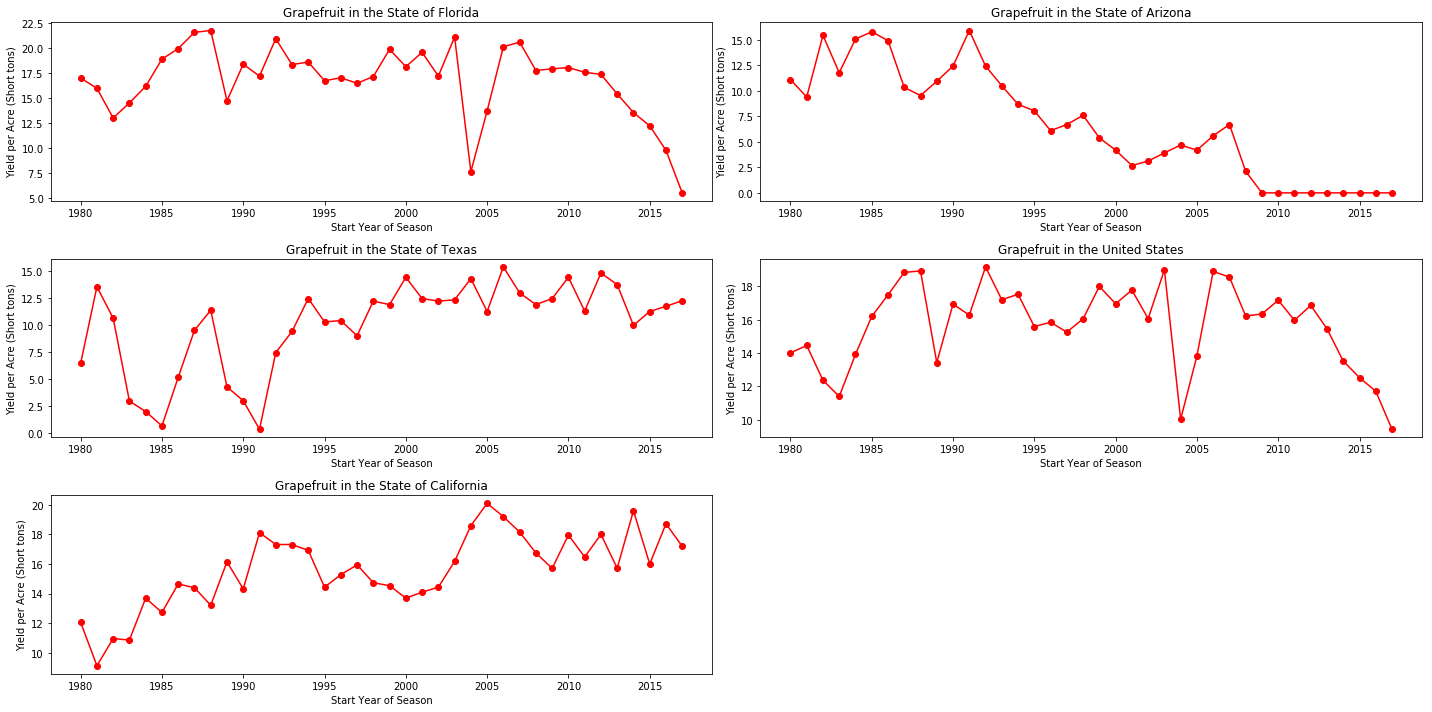

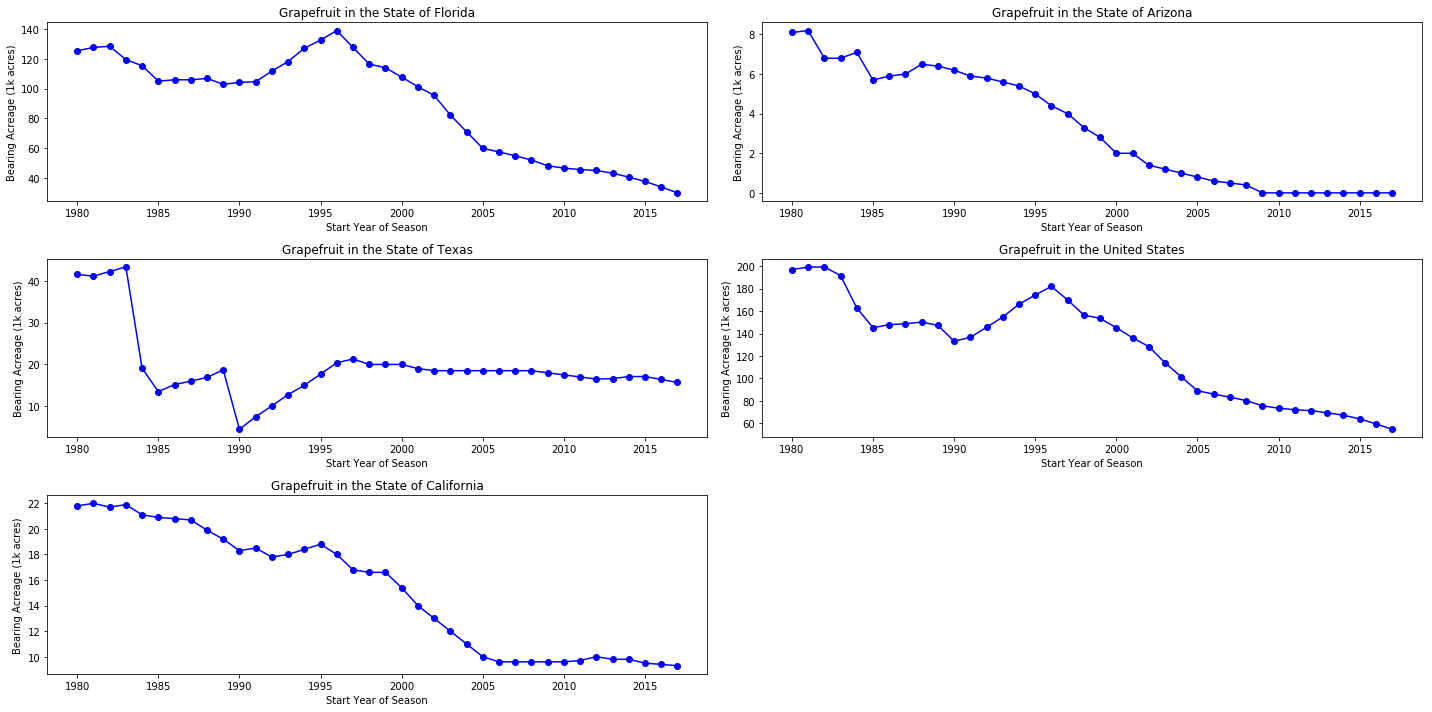

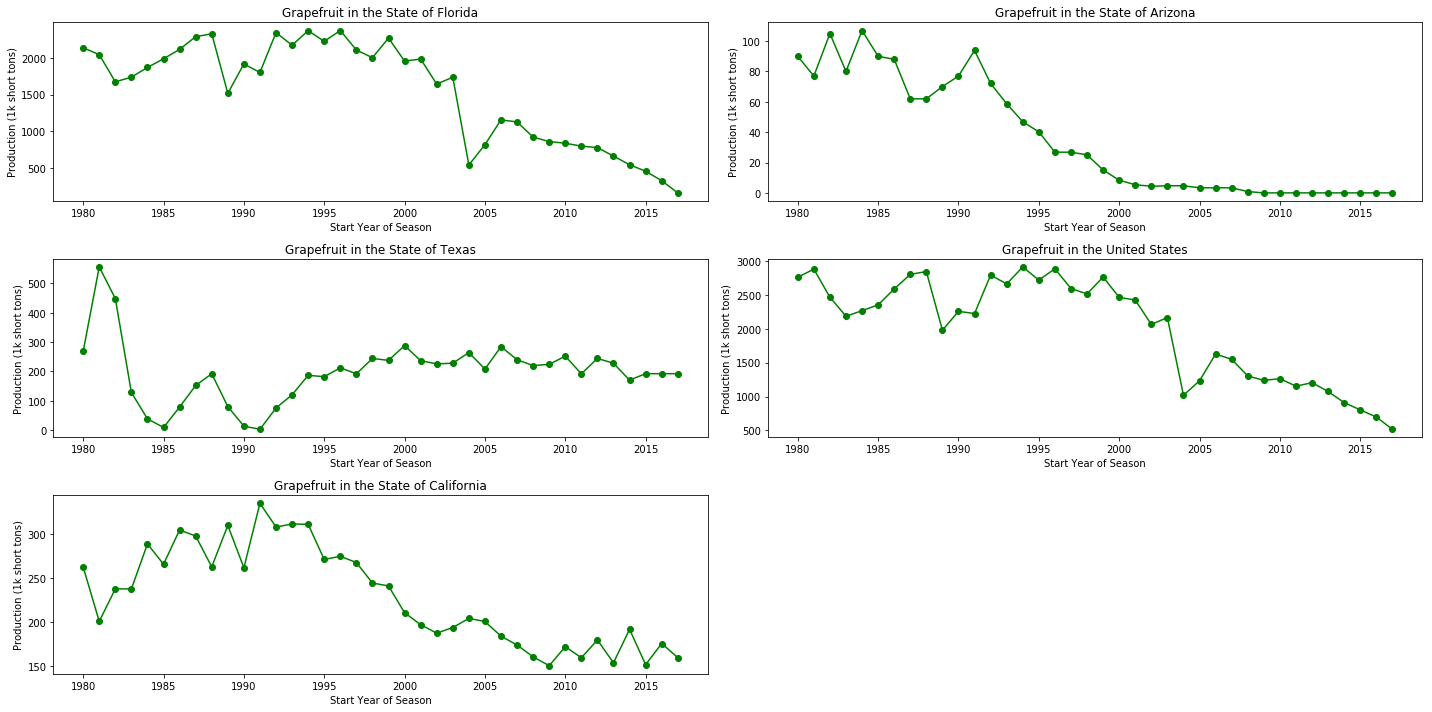

In [3]:
plot_time_series(cleaned_data_grapefruit, 'Grapefruit', YearbookPlotType.YIELD_PER_ACRE)
plot_time_series(cleaned_data_grapefruit, 'Grapefruit', YearbookPlotType.BEARING_ACREAGE)
plot_time_series(cleaned_data_grapefruit, 'Grapefruit', YearbookPlotType.PRODUCTION)

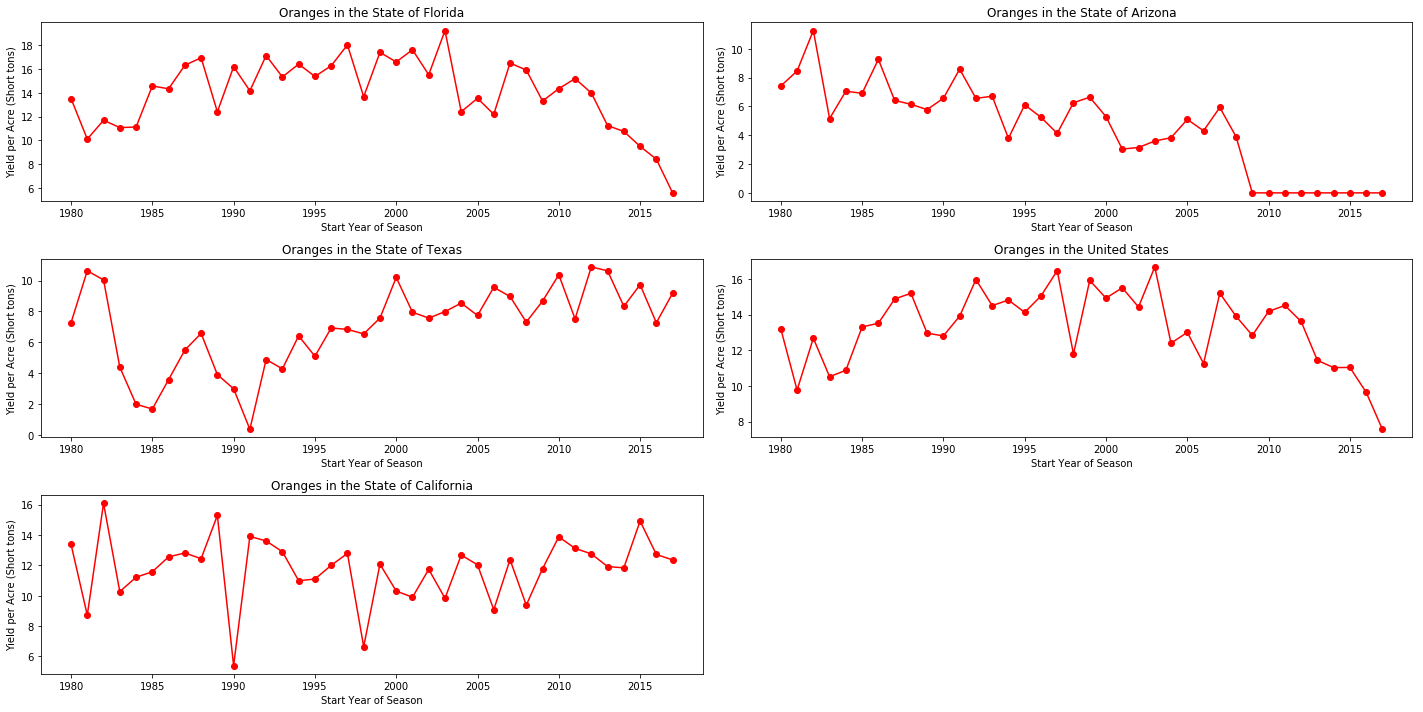

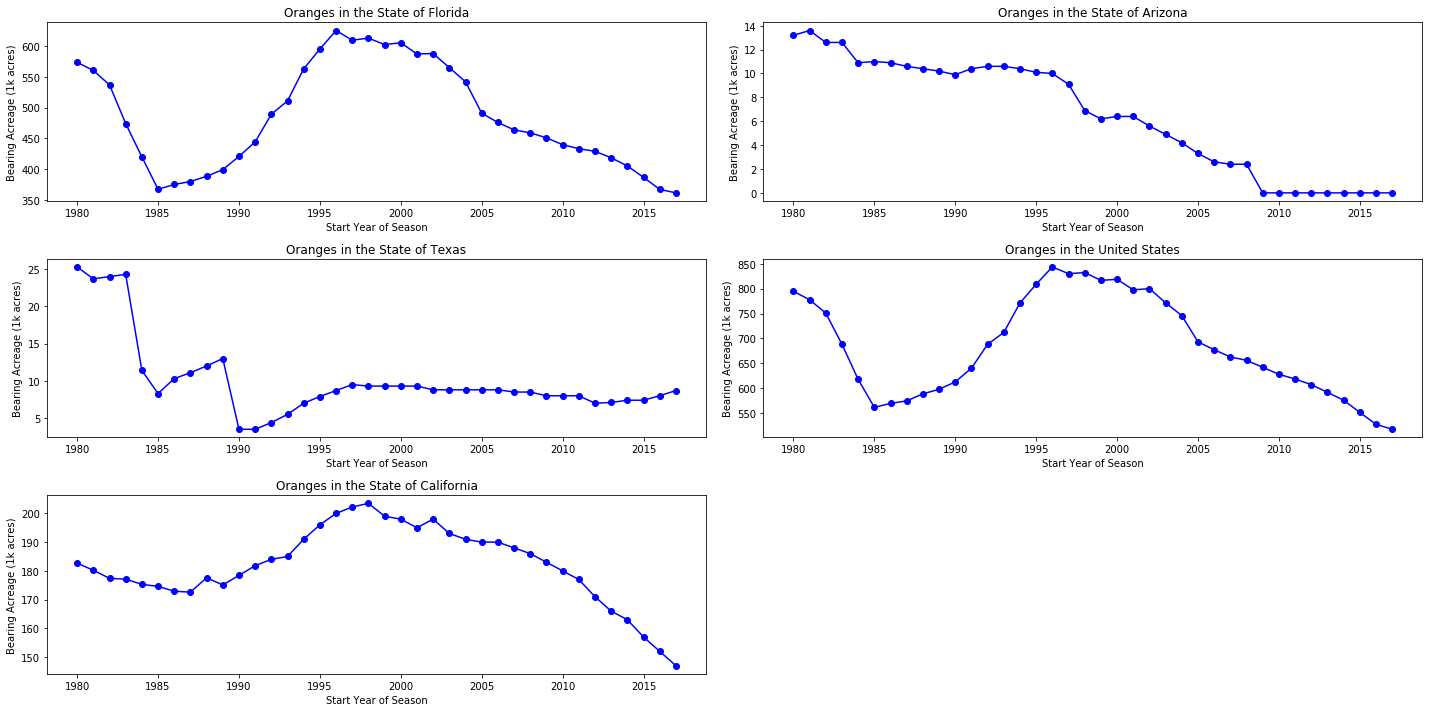

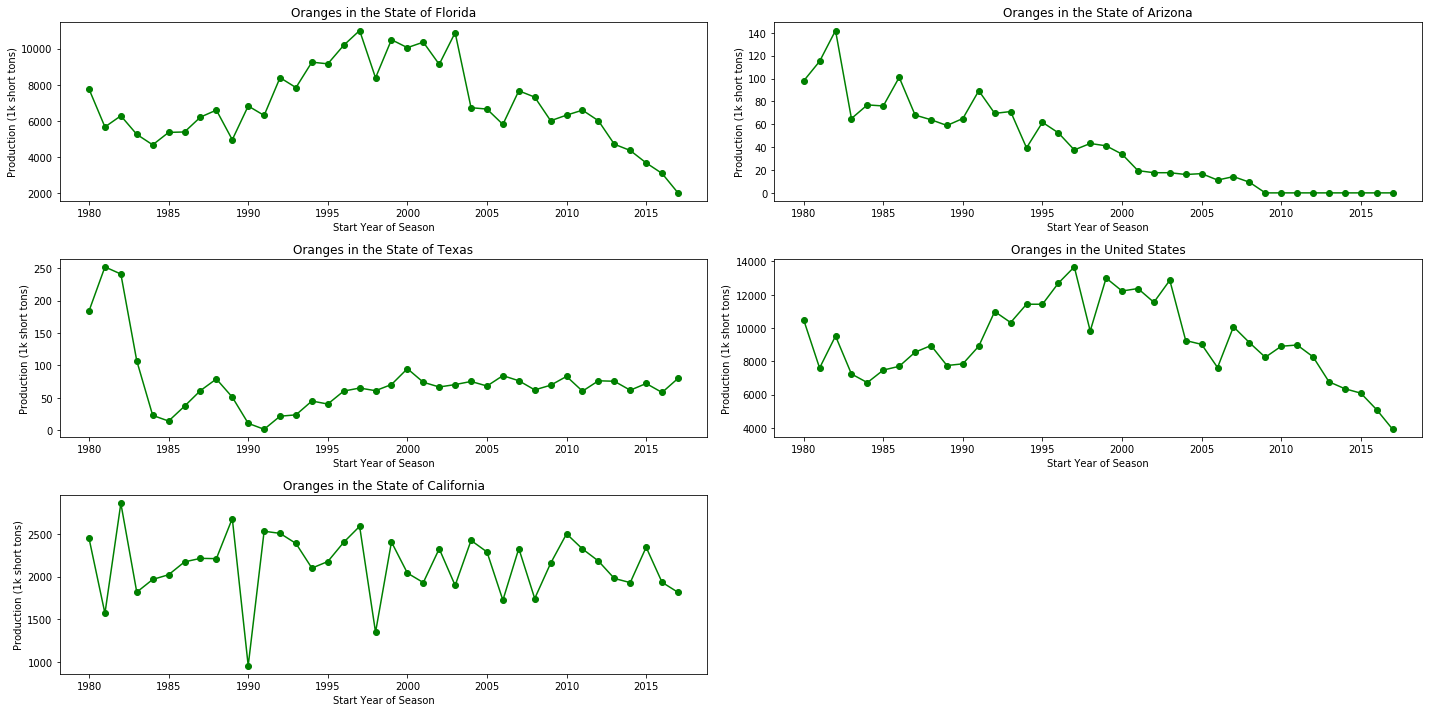

In [4]:
plot_time_series(cleaned_data_oranges, 'Oranges', YearbookPlotType.YIELD_PER_ACRE)
plot_time_series(cleaned_data_oranges, 'Oranges', YearbookPlotType.BEARING_ACREAGE)
plot_time_series(cleaned_data_oranges, 'Oranges', YearbookPlotType.PRODUCTION)

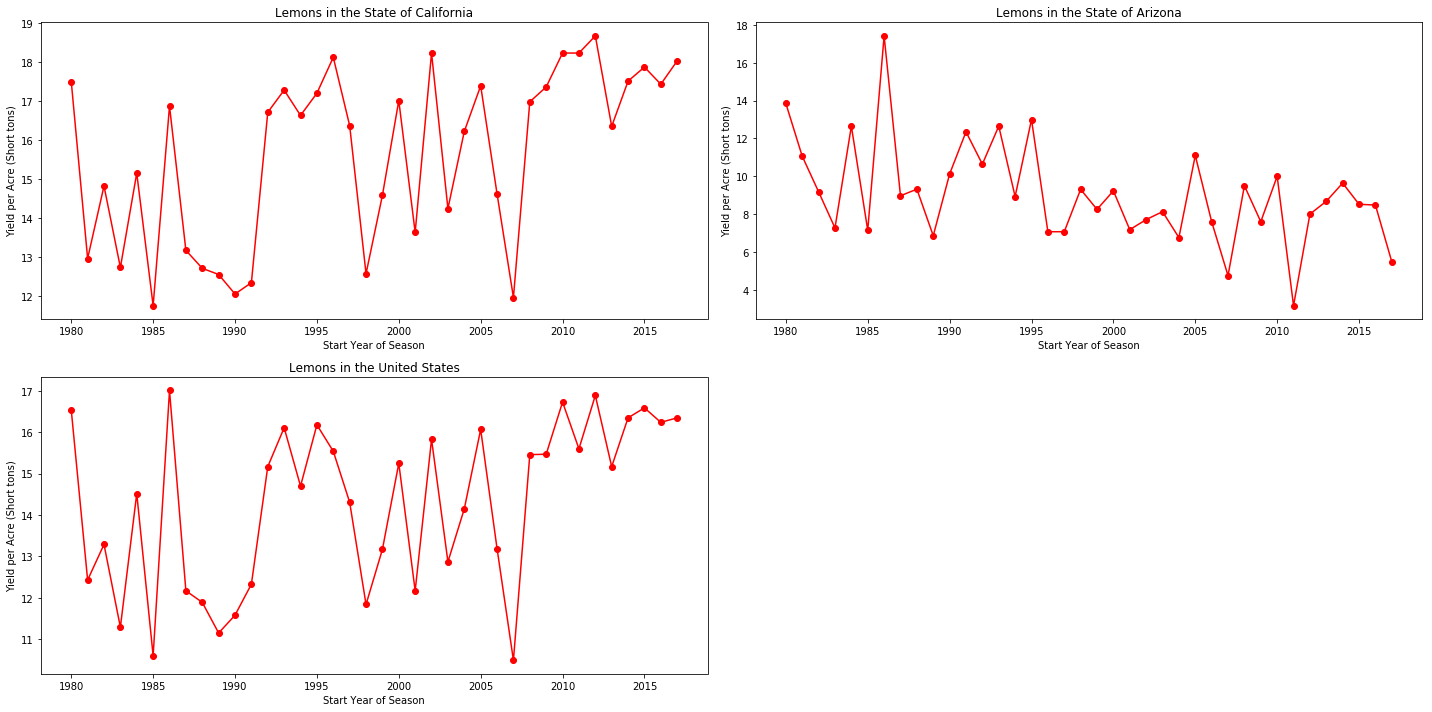

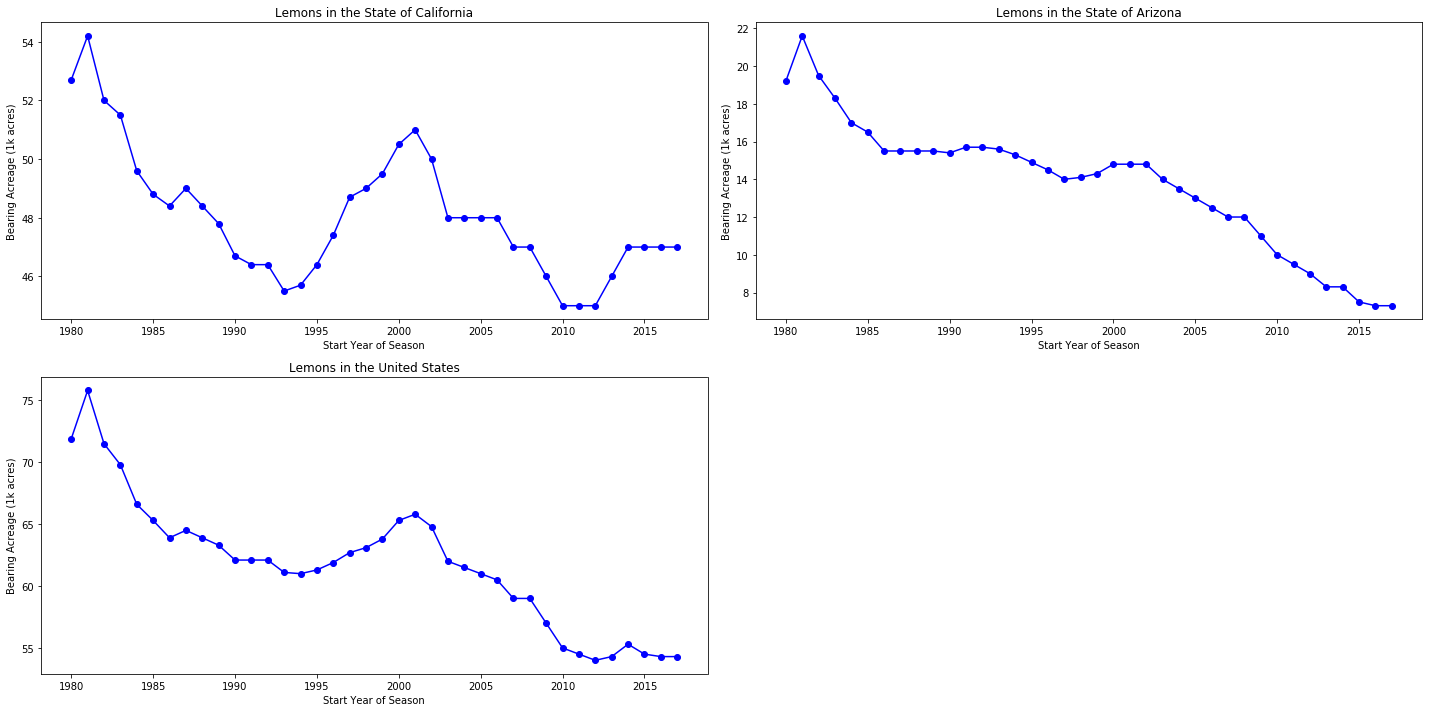

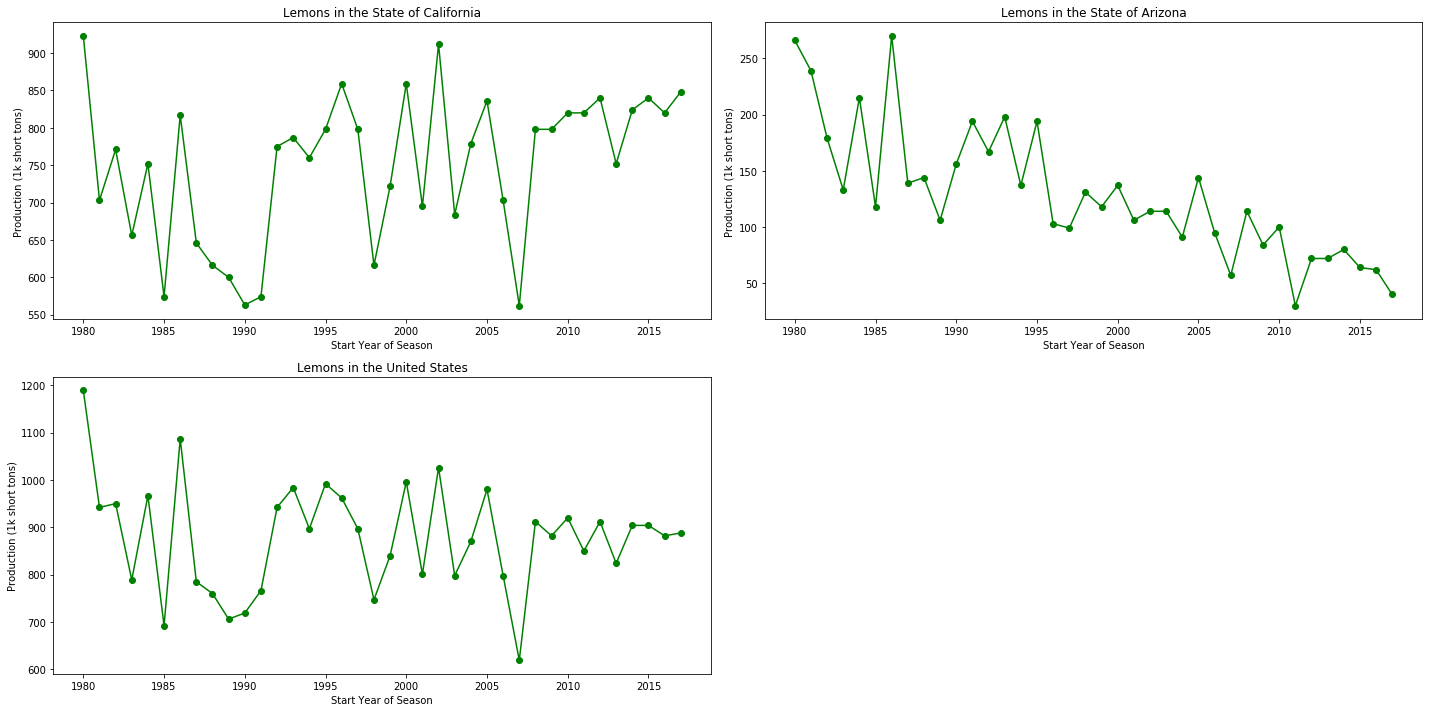

In [5]:
plot_time_series(cleaned_data_lemons, 'Lemons', YearbookPlotType.YIELD_PER_ACRE)
plot_time_series(cleaned_data_lemons, 'Lemons', YearbookPlotType.BEARING_ACREAGE)
plot_time_series(cleaned_data_lemons, 'Lemons', YearbookPlotType.PRODUCTION)

# Average Production of Citrus Crops by State

- Here we plot pie charts for each of the four states, showing the average production of each of the three major citrus crops (Lemons, Grapefruit, and Oranges) as a fraction of the total average production of each state.

- We see that of the four states highlighted by USDA as the major producers of citrus, only Arizona and California have production data for oranges, lemons, and grapefruit.

- In order to narrow the scope of our data analysis, we have decided to select only one of the four major citrus producing states to analyze more deeply, in trying to determine which extrinsic factors have contributed most significantly to the observed decline in citrus production over the past four decades.

- While both Arizona and California have historically produced enough of all three crops to warrant having the USDA report census information on them, in recent years, bearing acreage for both oranges and grapefruit have dropped to such a low level in the state of Arizona that the USDA is no longer those crops in its census reporting for Arizona.

- Therefore, we have decided to focus our analysis on citrus production in the state of California, because this state still produces enough of all three citrus crops to warrant having this production data reported by USDA.

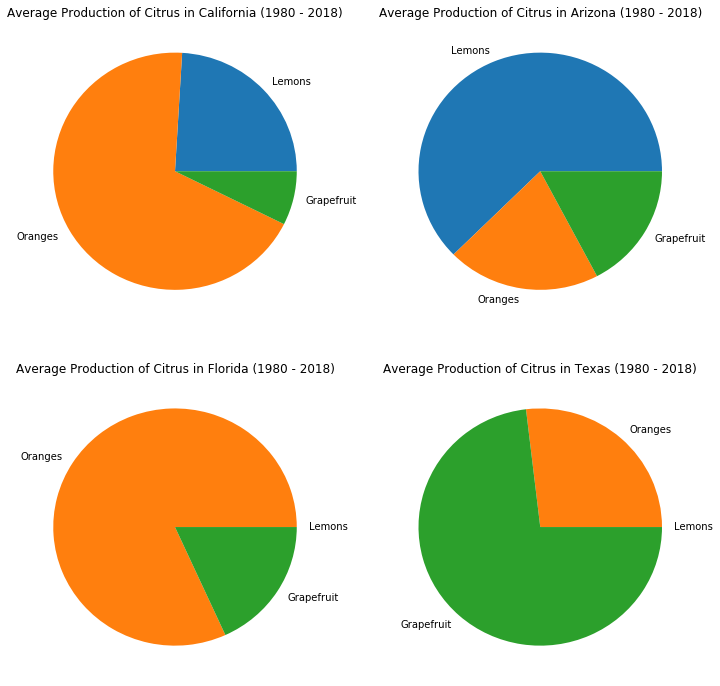

In [6]:
# Plot pie charts of average production for each of the major citrus crops, for each state

def average(items):
    
    if len(items) == 0:
        return len(items)
    
    return sum(items) / len(items)

states = ['California', 'Arizona', 'Florida', 'Texas']

curr_subplot = 1

plt.rcParams['figure.figsize'] = (12, 12)

for state in states:

    lemons_data_state = [row for row in cleaned_data_lemons if row[1] == state]
    oranges_data_state = [row for row in cleaned_data_oranges if row[1] == state]
    grapefruit_data_state = [row for row in cleaned_data_grapefruit if row[1] == state]

    lemons_production_state = [row[4] for row in lemons_data_state]
    oranges_production_state = [row[2] * row[3] for row in oranges_data_state]
    grapefruit_production_state = [row[2] * row[3] for row in grapefruit_data_state]

    avg_lemons_state = average(lemons_production_state)
    avg_oranges_state = average(oranges_production_state)
    avg_grapefruit_state = average(grapefruit_production_state)

    xs = [avg_lemons_state, avg_oranges_state, avg_grapefruit_state]

    plt.subplot(2, 2, curr_subplot)
    plt.pie(xs, labels=["Lemons", "Oranges", "Grapefruit"])
    curr_subplot += 1
    plt.title('Average Production of Citrus in ' + state + ' (1980 - 2018)')
    
plt.show()

In [12]:
from pathlib import Path
import csv
import codecs

# helper function which reads the csv_files containing lcd data
def read_ncdc_weather_data():
    csv_reads = []
    csv_files = []
    p = Path('./ncdc/lcd/california')
    
    for x in p.iterdir():  
        if x.is_dir():
            county_path = Path(x)  
            for x in county_path.iterdir():
                if x.is_file():
                    csv_files.append(x)
    for file in csv_files:
        if str(file)[-3:] == '.csv':
            print('reading ' + str(file))
            with codecs.open(str(file), 'rb', 'utf-8') as csv_file:
                file_data = []
                reader = csv.reader(csv_file)
                for row in reader:
                    file_data.append(row)
                csv_reads.append(file_data)
    return csv_reads
            
                            
csv_reads = read_ncdc_weather_data()
    

In [23]:
import sqlite3
from sqlite3 import Error

# fetch the weather station readings gathered from the ncdc by county
counties = ['Fresno', 'Ventura', 'Kern', 'Riverside', 'Tulare']
selections_average_daily = 'STATION_NAME, date(DATE) as DT, AVG(HOURLYDRYBULBTEMPF), AVG(HOURLYRelativeHumidity)'
group_by_average_daily = ' GROUP BY DT'
selections_average_yearly = 'STATION_NAME, substr(DATE, 1, 4) as YEAR, AVG(HOURLYDRYBULBTEMPF), AVG(HOURLYRelativeHumidity)'
group_by_average_yearly = ' GROUP BY YEAR'
queries = [
    (selections_average_daily, group_by_average_daily), 
    (selections_average_yearly, group_by_average_yearly),
]
data_collections = []

for county in counties:
    county_fetch = [county]
    conn = sqlite3.connect('./ncdc/lcd/california/' + county + '/' + county.lower() + '.db')
    cursor = conn.cursor()
    cursor.execute('SELECT name from sqlite_master WHERE type = "table"')
    tables = cursor.fetchall()
    for (table, ) in tables:
        for select, group in queries:
            cursor.execute('SELECT ' + select + ' FROM ' + table + group)
            county_fetch.append(cursor.fetchall())
    data_collections.append(county_fetch)
    
#conn = sqlite3.connect('./ncdc/lcd/california/Fresno/fresno.db')

#cursor = conn.cursor()

#cursor.execute('SELECT ' + selections + 'FROM fresno00_09 GROUP BY date(DATE)')
#data = cursor.fetchall()
print(len(data_collections))

fresno_data = data_collections[0]
ventura_data = data_collections[1]
kern_data = data_collections[2]
riverside_data = data_collections[3]
tulare_data = data_collections[4]

conn.close()

In [63]:
# aggregate yearly, monthly, and daily average temperature and humidity readings for the state of california
conn = sqlite3.connect('./ncdc/lcd/california/california.db')
cursor = conn.cursor()
cursor.execute('SELECT substr(DATE, 1, 4) as YEAR, AVG(HOURLYDRYBULBTEMPF), AVG(HOURLYRelativeHumidity) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY YEAR')
california_yearly_averages = cursor.fetchall()

cursor.execute('SELECT date(DATE) as DT, AVG(HOURLYDRYBULBTEMPF), AVG(HOURLYRelativeHumidity) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY DT')
california_daily_averages = cursor.fetchall()

cursor.execute('SELECT substr(DATE, 1, 7) as MONTH, AVG(HOURLYDRYBULBTEMPF), AVG(HOURLYRelativeHumidity) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY MONTH')
california_monthly_averages = cursor.fetchall()

cursor.close()
print(california_yearly_averages)

[('2000', 62.37925576814857, 65.337120146314), ('2001', 63.04289176941722, 64.42118944743036), ('2002', 62.5106013208203, 62.918143899895725), ('2003', 63.99135283944517, 64.95768185508065), ('2004', 63.18294237194723, 61.40622093624057), ('2005', 63.15528465324701, 64.59716317061553), ('2006', 62.620637370010066, 60.94749412948675), ('2007', 61.581198428025445, 57.75716774481073), ('2008', 62.33091639389158, 60.744904213560076), ('2009', 61.83883459339849, 62.164919259239745), ('2010', 61.20380897058213, 66.41962297553351), ('2011', 60.806963904435825, 63.793811828024914), ('2012', 63.161073658238735, 60.53043651634288), ('2013', 64.39047867878604, 52.06764208412976), ('2014', 66.28551077496891, 54.66566514711977), ('2015', 65.55001862891207, 57.40092080051097), ('2016', 64.39263922206301, 60.473363064092865), ('2017', 64.56373150720331, 61.70871826345371), ('2018', 66.0563915431495, 57.87598751034535)]


In [67]:
# aggregate yearly, monthly, and daily maximum temperature and humidity readings for the state of california
conn = sqlite3.connect('./ncdc/lcd/california/california.db')
cursor = conn.cursor()
cursor.execute('SELECT substr(DATE, 1, 4) as YEAR, MAX(CAST(HOURLYDRYBULBTEMPF as integer)), \
MAX(CAST(HOURLYRelativeHumidity as integer)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY YEAR')
california_yearly_max = cursor.fetchall()

cursor.execute('SELECT date(DATE) as DT, MAX(CAST(HOURLYDRYBULBTEMPF as integer)), \
MAX(CAST(HOURLYRelativeHumidity as integer)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY DT')
california_daily_max = cursor.fetchall()

cursor.execute('SELECT substr(DATE, 1, 7) as MONTH, MAX(CAST(HOURLYDRYBULBTEMPF as integer)), \
MAX(CAST(HOURLYRelativeHumidity as integer)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY MONTH')
california_monthly_max = cursor.fetchall()

cursor.close()
print(california_yearly_max)

[('2000', 108, 100), ('2001', 110, 100), ('2002', 108, 100), ('2003', 108, 100), ('2004', 106, 100), ('2005', 108, 100), ('2006', 113, 100), ('2007', 110, 100), ('2008', 112, 107), ('2009', 110, 100), ('2010', 113, 100), ('2011', 107, 100), ('2012', 110, 102), ('2013', 110, 100), ('2014', 109, 100), ('2015', 109, 100), ('2016', 113, 100), ('2017', 111, 100), ('2018', 117, 100)]


In [68]:
# aggregate yearly, monthly, and daily minimum temperature and humidity readings for the state of california
conn = sqlite3.connect('./ncdc/lcd/california/california.db')
cursor = conn.cursor()
cursor.execute('SELECT substr(DATE, 1, 4) as YEAR, MIN(CAST(HOURLYDRYBULBTEMPF as integer)), \
MIN(CAST(HOURLYRelativeHumidity as integer)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY YEAR')
california_yearly_min = cursor.fetchall()

cursor.execute('SELECT date(DATE) as DT, MIN(CAST(HOURLYDRYBULBTEMPF as integer)), \
MIN(CAST(HOURLYRelativeHumidity as integer))FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY DT')
california_daily_min = cursor.fetchall()

cursor.execute('SELECT substr(DATE, 1, 7) as MONTH, MIN(CAST(HOURLYDRYBULBTEMPF as integer)), \
MIN(CAST(HOURLYRelativeHumidity as integer)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY MONTH')
california_monthly_min = cursor.fetchall()

cursor.close()

In [69]:
print(california_yearly_min)
print(california_monthly_min[:24])


[('2000', 27, 6), ('2001', 30, 5), ('2002', 28, 7), ('2003', 30, 8), ('2004', 26, 6), ('2005', 30, 5), ('2006', 27, 3), ('2007', 19, 3), ('2008', 25, 2), ('2009', 25, 3), ('2010', 23, 4), ('2011', 23, 2), ('2012', 25, 2), ('2013', 22, 2), ('2014', 27, 2), ('2015', 23, 4), ('2016', 18, 3), ('2017', 7, 2), ('2018', 20, 3)]
[('2000-01', 27, 16), ('2000-02', 35, 12), ('2000-03', 37, 14), ('2000-04', 41, 11), ('2000-05', 43, 12), ('2000-06', 48, 13), ('2000-07', 52, 11), ('2000-08', 54, 12), ('2000-09', 53, 13), ('2000-10', 44, 12), ('2000-11', 31, 13), ('2000-12', 29, 6), ('2001-01', 30, 5), ('2001-02', 30, 13), ('2001-03', 38, 27), ('2001-04', 36, 17), ('2001-05', 45, 9), ('2001-06', 50, 8), ('2001-07', 50, 12), ('2001-08', 54, 13), ('2001-09', 48, 13), ('2001-10', 48, 17), ('2001-11', 34, 19), ('2001-12', 32, 11)]


In [70]:
days_below_yearly_average_temp = []
days_above_yearly_average_temp = []
days_below_monthly_average_temp = []
days_above_monthly_average_temp = []

date, temp, humid = california_daily[1]
print(date)
print(date[:4])
print(california_yearly[:-1])

2000-01-01
2000
[('2000', 60.015959425190196, 62.81200338123415), ('2001', 60.5754395437519, 61.886342928491885), ('2002', 60.08387872312007, 60.44326833177508), ('2003', 60.009157630256546, 60.84521290663846), ('2004', 59.612515433101564, 57.92072259406069), ('2005', 60.72007650125246, 61.97212443301063), ('2006', 61.16658151568743, 59.502351477041984), ('2007', 56.53903764499078, 52.94246171748307), ('2008', 57.41652428460481, 55.654220682239085), ('2009', 56.25235592063511, 56.514375007483864), ('2010', 53.89243201393593, 58.09467240878738), ('2011', 59.35275425023528, 61.713587308571356), ('2012', 61.57394707507391, 58.856043716376675), ('2013', 58.75069575028206, 47.466603986461074), ('2014', 63.59749646077044, 52.41864739338847), ('2015', 62.96961103659705, 55.10371080028102), ('2016', 61.48033492087878, 57.70751267475803), ('2017', 62.197228874444065, 59.41524896588188), ('2018', 63.57691959844443, 55.65558469747671)]


In [71]:
for year, ytemp, yhumidity in california_yearly[:-1]:
    current_year = [year]
    
    days_below = [(date, temp, humidity) for (date, temp, humidity) in california_daily[1:] if date[:4] == year and temp < ytemp]
    days_below_yearly_average_temp.append(current_year + [len(days_below)])
    
    days_above = [(date, temp, humidity) for (date, temp, humidity) in california_daily[1:] if date[:4] == year and temp > ytemp]
    days_above_yearly_average_temp.append(current_year + [len(days_above)])


In [72]:
print(days_above_yearly_average_temp)

[['2000', 178], ['2001', 189], ['2002', 182], ['2003', 173], ['2004', 201], ['2005', 164], ['2006', 170], ['2007', 186], ['2008', 171], ['2009', 195], ['2010', 173], ['2011', 174], ['2012', 178], ['2013', 202], ['2014', 183], ['2015', 184], ['2016', 182], ['2017', 169], ['2018', 158]]


In [73]:
print(days_below_yearly_average_temp)

[['2000', 188], ['2001', 176], ['2002', 183], ['2003', 192], ['2004', 165], ['2005', 201], ['2006', 195], ['2007', 179], ['2008', 195], ['2009', 170], ['2010', 192], ['2011', 191], ['2012', 188], ['2013', 163], ['2014', 182], ['2015', 181], ['2016', 184], ['2017', 196], ['2018', 161]]


Text(0,0.5,'Average Daily Humidity')

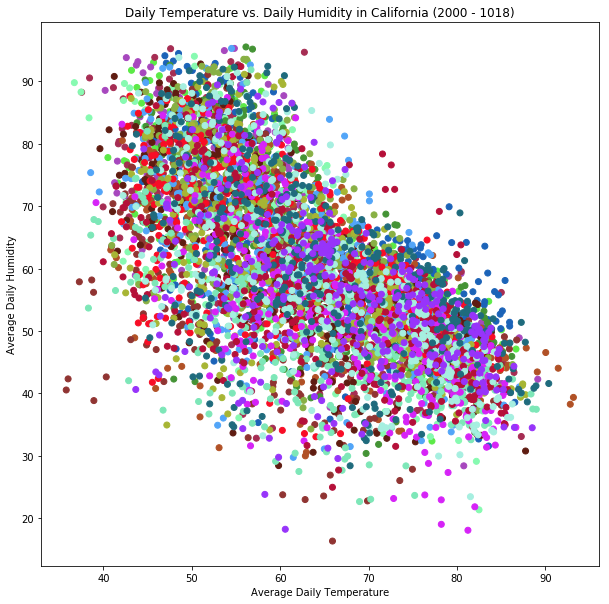

In [80]:
california_daily_dates = [date for (date, temp, humid) in california_daily_averages]
california_daily_temps = [temp for (date, temp, humid) in california_daily_averages]
california_daily_humids = [humid for (date, temp, humid) in california_daily_averages]
colors = [(np.random.random(), np.random.random(), np.random.random()) for data in california_yearly_averages]
color_dict = dict(list(zip([year for (year, temp, humid) in california_yearly_averages], colors)))
california_daily_colors = [color_dict[date[:4]] for (date, temp, humid) in california_daily_averages]

plt.rcParams['figure.figsize'] = (10, 10)
plt.scatter(california_daily_temps, california_daily_humids, c=california_daily_colors)
plt.title('Daily Temperature vs. Daily Humidity in California (2000 - 1018)')
plt.xlabel('Average Daily Temperature')
plt.ylabel('Average Daily Humidity')

In [79]:
dict([(1, 3), (5, 10)])

{1: 3, 5: 10}